# Flow Visualization

In [1]:
from copy import deepcopy
import random

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch as th

from lib.augmentation import FlowNetAugmentation
from lib.datasets.flow.flyingchairs import FlyingChairsTrain, FlyingChairsTest
from lib.datasets.flow.flyingthings3d import FlyingThings3DTrain, FlyingThings3DTest
from lib.datasets.flow.sintel import SintelTrain, SintelTest, SintelFullTrain
from lib.utils import get_checkpoint
from lib.flownet import FlowNetC, FlowNetS
from lib.vis import np3d, np2d
from eval import restore, sample_to_device
from lib.metrics import compute_flow_metrics


## Plotting code

In [2]:
def add_colorbar(fig, fig_imshow, ax):
    """Add colorbar to a given figure"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(fig_imshow, cax=cax)


def view_image(image, title="untitled", figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    fig_imshow = plt.imshow(image)
    ax = fig.get_axes()[0]
    if image.ndim == 2:
        # automatically add a colorbar for data with 2 dimensions (i.e. not RGB)
        add_colorbar(fig, fig_imshow, ax)
    ax.set_axis_off()
    plt.show()


def visualize_flow(flow, title="untitled"):
    """
    Based on:
        https://stackoverflow.com/questions/28898346/visualize-optical-flow-with-color-model
        https://stackoverflow.com/questions/73554127/converting-cartesian-coordinates-to-polar-coordinates-with-numpy
    """
    rgb = np3d(flow, channels="FLOW", text=title)
    display(rgb)


## Create and view example flow field

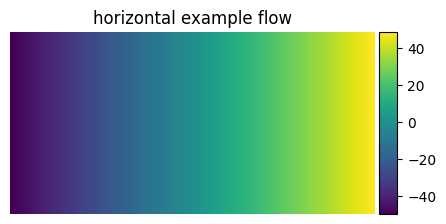

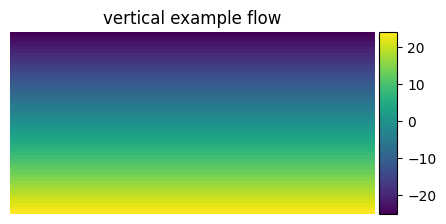

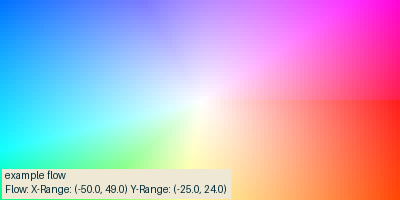

In [3]:
# create example flow that points away from the center
ex_h, ex_w = 50, 100
scale = 1
us = np.linspace(-ex_w / 2, ex_w / 2 - 1, ex_w) * scale
vs = np.linspace(-ex_h / 2, ex_h / 2 - 1, ex_h) * scale
u, v = np.meshgrid(us, vs)

ex_flow = np.zeros((ex_h, ex_w, 2), dtype=np.float32)
ex_flow[..., 0] = u
ex_flow[..., 1] = v

view_image(ex_flow[..., 0], "horizontal example flow", (5, 5))
view_image(ex_flow[..., 1], "vertical example flow", (5, 5))
visualize_flow(ex_flow, "example flow")


## Create and view train dataset

In [4]:
# fix seed so the augmentation stays the same
seed = 1
th.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


def create_train_dataloader(dset_name):
    if dset_name == "FlyingThings3D":
        dataset_cls = FlyingThings3DTrain
    elif dset_name == "FlyingChairs":
        dataset_cls = FlyingChairsTrain
    elif dset_name == "Sintel":
        dataset_cls = SintelTrain
    else:
        raise ValueError(f"Unknown dataset: {dset_name}")
    aug_fct = FlowNetAugmentation()
    dataloader = dataset_cls.init_as_loader(
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        aug_fcts=aug_fct,
    )
    return dataloader


dataloader = create_train_dataloader("Sintel")
train_sample = next(iter(dataloader))


Initializing dataset SintelTrain from /project/cv-ws2425/lmb/data/Sintel/data/training.
	Initializing samples from list at /project/cv-ws2425/lmb/data/Sintel/sample_lists/flow.SintelTrain.pickle.
	Number of samples: 943
Finished initializing dataset SintelTrain.



Meta information
    _base:/project/cv-ws2425/lmb/data/Sintel/data/training
    _name:ambush_2/key0001
    _keyview_idx:0
    _index:0
    _dataset:SintelTrain
    _orig_height:436
    _orig_width:1024
    _spatial_aug_scaled_height:575
    _spatial_aug_scaled_width:1350
    _spatial_aug_crop_y:8
    _spatial_aug_crop_x:431


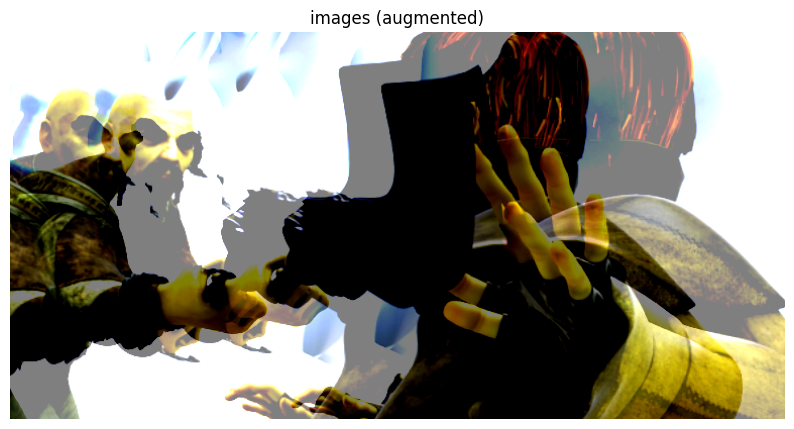

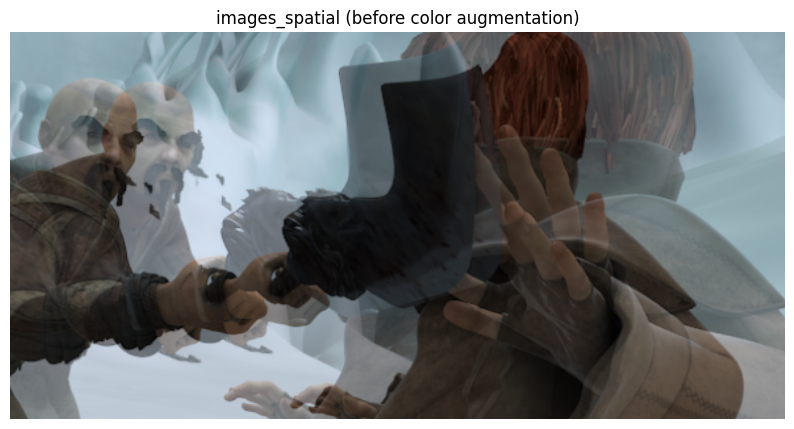

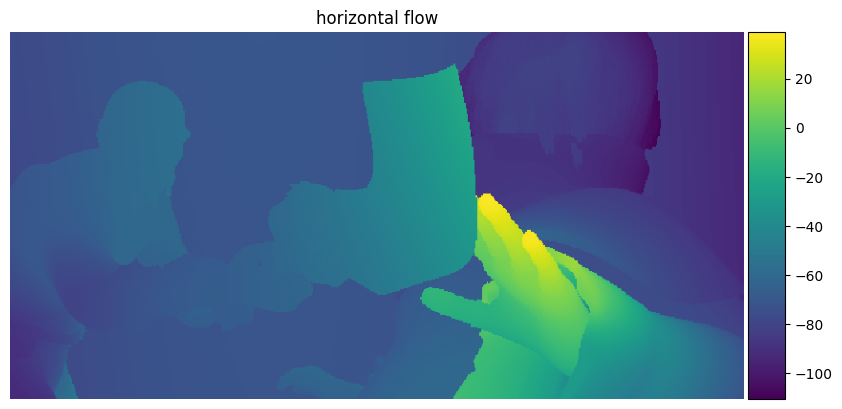

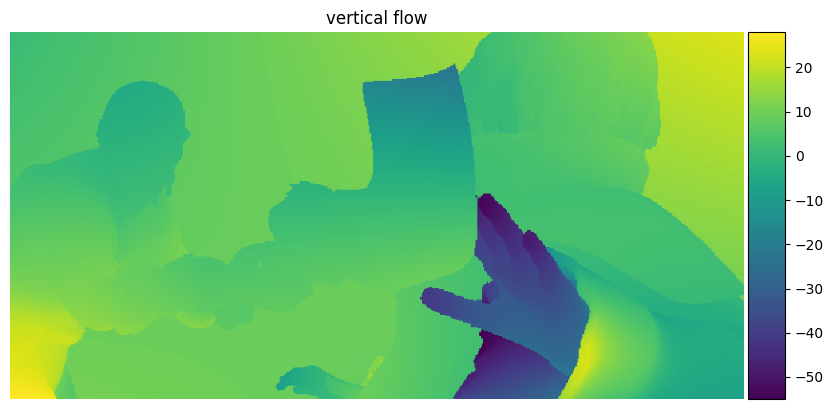

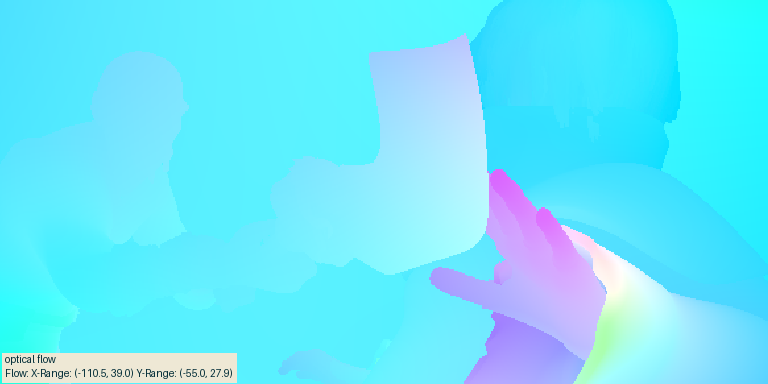

In [5]:
def convert_image_to_numpy(image_torch):
    # convert torch (C, H, W) to numpy / matplotlib (H, W, C)
    return np.transpose(image_torch.detach().cpu().numpy(), (1, 2, 0))


def convert_image_list(image_list, batch_idx=0, overlay=True):
    # input is list of [B, 3, H, W]
    image_list_nobatch = [image[batch_idx] for image in image_list]
    if overlay:
        # overlay images on top of each other
        images_stacked = (image_list_nobatch[0] + image_list_nobatch[1]) / 2
    else:
        # stack images vertically
        images_stacked = th.cat([image_list_nobatch[0], image_list_nobatch[1]], axis=1)
    images_np = convert_image_to_numpy(images_stacked)
    return images_np


def view_sample(sample, batch_idx=0, overlay=True, view_separate_flow=True):
    batch_idx = 0
    sample_copy = deepcopy(sample)
    print(f"Meta information")
    for k in list(sample_copy.keys()):
        if k[0] == "_":
            v = sample_copy.pop(k)[batch_idx]
            print(f"    {k}:{v}")

    images = sample_copy.pop("images")
    images_np = convert_image_list(images)
    images_np += 0.4  # images are in range (-0.4 to 0.6), undo the normalization
    view_image(images_np, "images (augmented)")

    images_spatial = sample_copy.pop("images_spatial")
    images_spatial_np = convert_image_list(images_spatial)
    images_spatial_np /= 255.0  # images_spatial is in range (0, 255)
    view_image(images_spatial_np, "images_spatial (before color augmentation)")

    gt_flow = sample_copy.pop("gt_flow")  # (B, 2, H, W)
    gt_flow_nobatch = gt_flow[batch_idx]
    gt_flow_np = convert_image_to_numpy(gt_flow_nobatch)
    if view_separate_flow:
        view_image(gt_flow_np[..., 0], "horizontal flow")
        view_image(gt_flow_np[..., 1], "vertical flow")
    visualize_flow(gt_flow_np, "optical flow")


view_sample(train_sample)


## Create and view test dataset

Initializing dataset SintelTest from /project/cv-ws2425/lmb/data/Sintel/data/training.
	Initializing samples from list at /project/cv-ws2425/lmb/data/Sintel/sample_lists/flow.SintelTest.pickle.
	Number of samples: 98
Finished initializing dataset SintelTest.

Meta information
    _base:/project/cv-ws2425/lmb/data/Sintel/data/training
    _name:alley_1/key0001
    _keyview_idx:0
    _index:0
    _dataset:SintelTest
    _orig_height:436
    _orig_width:1024
    _spatial_aug_scaled_height:448
    _spatial_aug_scaled_width:1024
    _spatial_aug_crop_y:0
    _spatial_aug_crop_x:0


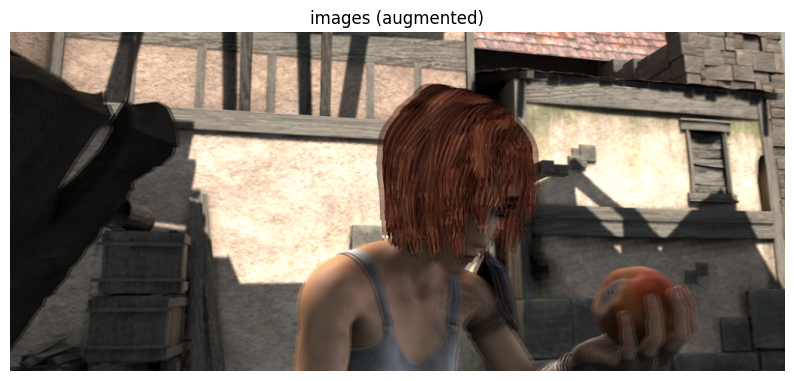

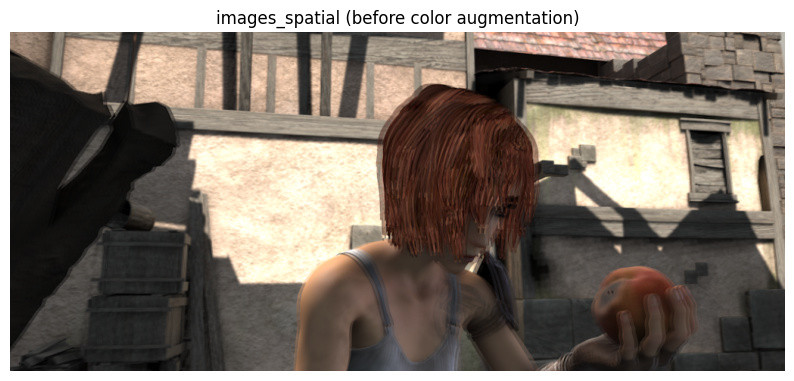

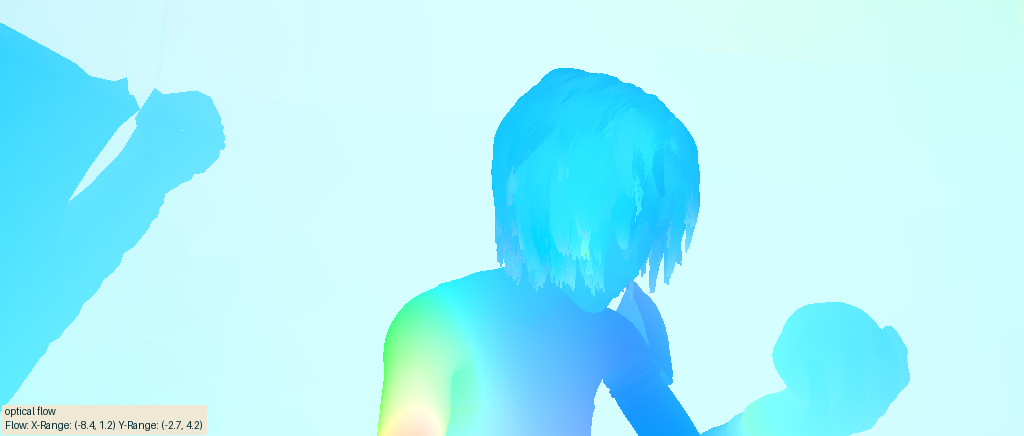

In [6]:
def create_test_dataloader(dset_name):
    if dset_name == "FlyingThings3D":
        dataset_cls = FlyingThings3DTest
    elif dset_name == "FlyingChairs":
        dataset_cls = FlyingChairsTest
    elif dset_name == "Sintel":
        dataset_cls = SintelTest
    elif dset_name == "SintelFull":
        dataset_cls = SintelFullTrain
    else:
        raise ValueError(f"Unknown dataset {dset_name}")

    preprocess_fct = FlowNetAugmentation()
    preprocess_fct.out_size = (
        None  # upscale to next height and width that are divisible by 64
    )
    preprocess_fct.spatial_aug_prob = 0.0  # only resize, no cropping
    preprocess_fct.color_aug_prob = 0.0  # no color augmentation
    preprocess_fct.augment_image_only = True  # do not resize the ground truth
    dataloader = dataset_cls.init_as_loader(
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        drop_last=False,
        aug_fcts=preprocess_fct,
    )
    return dataloader


test_dataloader = create_test_dataloader("Sintel")
test_sample = next(iter(test_dataloader))

view_sample(test_sample, view_separate_flow=False)


## Load and run model

In [7]:
device = "cuda"


def setup_model(model_name="FlowNetS", C=48, cuda_corr=False, device="cuda"):
    if model_name == "FlowNetC":
        model = FlowNetC(C=C, cuda_corr=cuda_corr)
    elif model_name == "FlowNetS":
        model = FlowNetS(C=C)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    model = model.to(device)
    model.eval()

    return model


model = setup_model(model_name="FlowNetS", device=device)
ckpt_path = get_checkpoint("pt/flownets")
restore(model, ckpt_path)


Restoring model weights from /project/cv-ws2425/lmb/data/OpticalFlowPretrainedModels/flownet_s/checkpoint-model-iter-000600000.pt



In [8]:
def run_model(model, sample):
    image_list = sample["images"]
    image_1 = image_list[0]
    image_2 = image_list[1]
    model_output_dict = model(image_1, image_2)
    return model_output_dict


test_sample_device = sample_to_device(test_sample, device)
model_output_dict = run_model(model, test_sample_device)
model_output_dict.keys()


dict_keys(['pred_flows_all', 'pred_flow'])

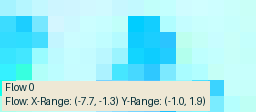

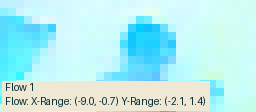

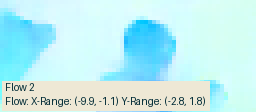

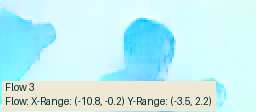

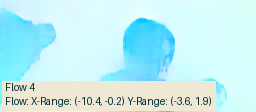

In [9]:
for i, flow in enumerate(model_output_dict["pred_flows_all"]):
    flow = flow[0]
    flow_np = convert_image_to_numpy(flow)
    visualize_flow(flow_np, f"Flow {i}")


## Compute metrics

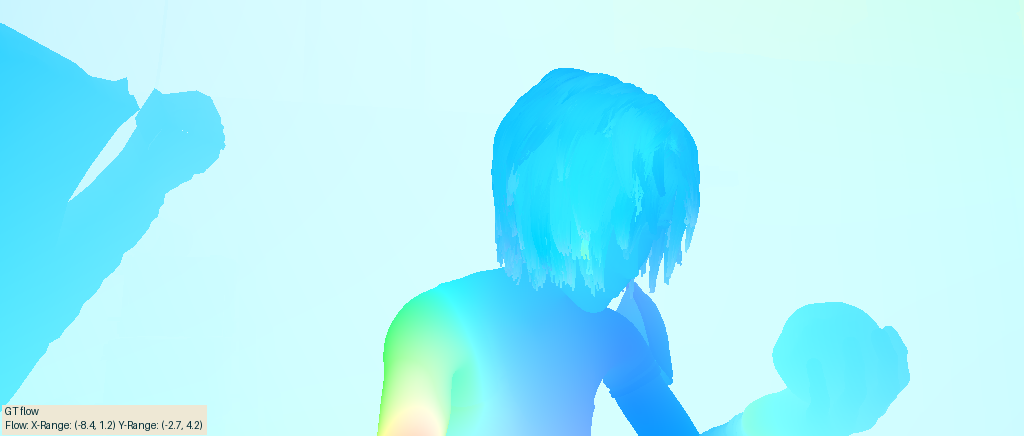

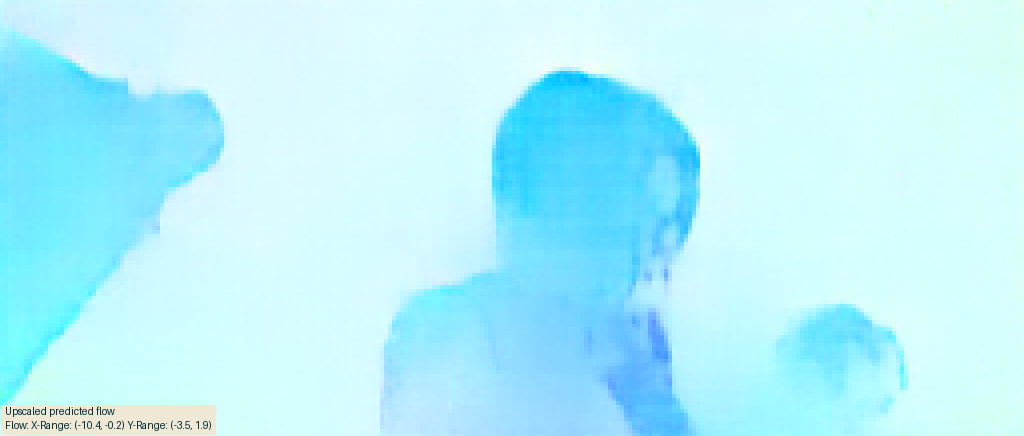

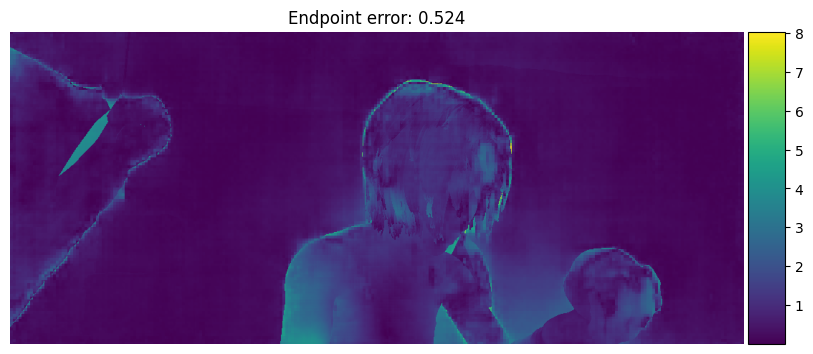

In [10]:
metrics, qualitatives = compute_flow_metrics(test_sample_device, model_output_dict)
epe_np = convert_image_to_numpy(qualitatives["epe"][0]).squeeze(-1)
scaled_pred_np = convert_image_to_numpy(qualitatives["pred_flow"][0])
gt_flow_np = convert_image_to_numpy(test_sample["gt_flow"][0])

visualize_flow(gt_flow_np, f"GT flow")
visualize_flow(scaled_pred_np, f"Upscaled predicted flow")
view_image(epe_np, f"Endpoint error: {metrics['aepe']:.3g}")
